## Modelos para la detección de Lesión Renal Aguda Postoperatoria

### Librerías

In [1]:
# importar librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

In [2]:
#Clonar repositorio
!git clone https://github.com/danielfce01/Monografia.git

Cloning into 'Monografia'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (9/9), 96.29 KiB | 16.05 MiB/s, done.


### Conjuntos de datos

#### df_aki

Conjunto de datos del trabajo original :

Incidencia y factores de riesgo de Lesión Renal Aguda en cirugía no cardiovascular en un Hospital Universitario de Medellín, Colombia

Contiene 488 registros

Problema : marcado desbalance en la variable target lra (lesion renal aguda)

In [3]:
df_aki = pd.read_excel('/content/Monografia/data_final_balanceada.xlsx')
df_aki.head()

,edad,dm,hta,ieca,asa,enfermedad_renal_cronica,creatinina_basal,sepsis,choque_hipovolemico_,cirugia_vascular,prioridad_urgente,lra
0,75,0,0,0,3,0,0.76,0,0,0,0,0
1,71,1,1,0,3,0,0.82,1,0,0,0,0
2,66,1,1,1,3,0,0.69,0,1,0,1,1
3,42,0,0,0,1,0,0.69,0,0,0,1,0
4,88,1,1,0,3,0,0.83,0,0,0,0,0


In [4]:
df_aki.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489 entries, 0 to 488
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   edad                      489 non-null    int64  
 1   dm                        489 non-null    int64  
 2   hta                       489 non-null    int64  
 3   ieca                      489 non-null    int64  
 4   asa                       489 non-null    int64  
 5   enfermedad_renal_cronica  489 non-null    int64  
 6   creatinina_basal          489 non-null    float64
 7   sepsis                    489 non-null    int64  
 8   choque_hipovolemico_      489 non-null    int64  
 9   cirugia_vascular          489 non-null    int64  
 10  prioridad_urgente         489 non-null    int64  
 11  lra                       489 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 46.0 KB


In [5]:
print(df_aki['lra'].value_counts())

lra
0    395
1     94
Name: count, dtype: int64


In [6]:
df_aki['asa'] = df_aki['asa'].replace({1: 0, 2: 0, 3: 1, 4: 1, 5: 1})
display(df_aki.head())

,edad,dm,hta,ieca,asa,enfermedad_renal_cronica,creatinina_basal,sepsis,choque_hipovolemico_,cirugia_vascular,prioridad_urgente,lra
0,75,0,0,0,1,0,0.76,0,0,0,0,0
1,71,1,1,0,1,0,0.82,1,0,0,0,0
2,66,1,1,1,1,0,0.69,0,1,0,1,1
3,42,0,0,0,0,0,0.69,0,0,0,1,0
4,88,1,1,0,1,0,0.83,0,0,0,0,0


####df_mimic


In [7]:
df_mimic = pd.read_csv('/content/Monografia/1710 ap_aki_features.csv')
df_mimic.head()

,subject_id,hadm_id,stay_id,intime,outtime,edad,gender,race,admission_type,insurance,...,aki_scr_stage,aki_uo,aki_7d,glucose_mean_24h,urine_24h_ml,intake_24h_ml,output_24h_ml,balance_hidrico_24h_ml,peso_kg,balance_hidrico_24h_mlkg
0,10004606,29242151,30213599,2159-02-20 16:10:03,2159-02-25 20:09:14,64,F,WHITE,OBSERVATION ADMIT,Other,...,NaN,0,0,131.000000,NaN,5851.571321,2215.0,3636.571321,NaN,NaN
1,10007795,28477357,31921355,2136-04-22 18:01:13,2136-04-23 19:13:58,53,F,WHITE,URGENT,Medicare,...,3.0,0,1,133.000000,NaN,2492.500023,5900.0,-3407.499977,NaN,NaN
2,10012206,23961896,37675714,2127-07-04 02:08:00,2127-07-04 15:52:22,45,M,WHITE,OBSERVATION ADMIT,Other,...,NaN,0,0,108.000000,NaN,2417.583356,1525.0,892.583356,NaN,NaN
3,10017531,21095812,32136798,2159-12-26 20:14:53,2160-02-04 16:23:00,64,M,WHITE,URGENT,Other,...,3.0,0,1,207.666667,NaN,2948.151587,745.0,2203.151587,NaN,NaN
4,10017531,22580355,35526828,2159-09-22 19:30:55,2159-10-24 14:57:16,64,M,WHITE,URGENT,Other,...,1.0,0,1,202.333333,NaN,10595.584131,1295.0,9300.584131,NaN,NaN


In [8]:
df_mimic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1069 entries, 0 to 1068
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   subject_id                1069 non-null   int64  
 1   hadm_id                   1069 non-null   int64  
 2   stay_id                   1069 non-null   int64  
 3   intime                    1069 non-null   object 
 4   outtime                   1069 non-null   object 
 5   edad                      1069 non-null   int64  
 6   gender                    1069 non-null   object 
 7   race                      1069 non-null   object 
 8   admission_type            1069 non-null   object 
 9   insurance                 1069 non-null   object 
 10  first_careunit            1069 non-null   object 
 11  dm                        1069 non-null   int64  
 12  hta                       1069 non-null   int64  
 13  enfermedad_renal_cronica  1069 non-null   int64  
 14  sepsis  

In [9]:
df_mimic = df_mimic[['edad', 'dm', 'hta', 'enfermedad_renal_cronica', 'sepsis', 'choque_hipovolemico_', 'ieca', 'asa', 'creatinina_basal', 'aki_7d']]
df_mimic = df_mimic.rename(columns={'aki_7d': 'lra'})
display(df_mimic.head())

,edad,dm,hta,enfermedad_renal_cronica,sepsis,choque_hipovolemico_,ieca,asa,creatinina_basal,lra
0,64,0,1,0,0,0,1,0,1.3,0
1,53,0,1,0,0,0,0,0,0.6,1
2,45,1,1,0,0,0,0,0,1.7,0
3,64,1,1,0,0,0,0,1,1.2,1
4,64,1,1,0,0,0,0,0,1.7,1


In [10]:
# Imputar valores faltantes en creatinina_basal con la media
df_mimic["creatinina_basal"].fillna(df_mimic["creatinina_basal"].mean(), inplace=True)

/tmp/ipython-input-2185084524.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_mimic["creatinina_basal"].fillna(df_mimic["creatinina_basal"].mean(), inplace=True)


In [11]:
df_mimic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1069 entries, 0 to 1068
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   edad                      1069 non-null   int64  
 1   dm                        1069 non-null   int64  
 2   hta                       1069 non-null   int64  
 3   enfermedad_renal_cronica  1069 non-null   int64  
 4   sepsis                    1069 non-null   int64  
 5   choque_hipovolemico_      1069 non-null   int64  
 6   ieca                      1069 non-null   int64  
 7   asa                       1069 non-null   int64  
 8   creatinina_basal          1069 non-null   float64
 9   lra                       1069 non-null   int64  
dtypes: float64(1), int64(9)
memory usage: 83.6 KB


In [12]:
print(df_mimic['lra'].value_counts())

lra
1    580
0    489
Name: count, dtype: int64


####df_udaki

In [13]:
df_mimic_2 = df_mimic.copy()

In [14]:
df_mimic_2['cirugia_vascular'] = 0
df_mimic_2['prioridad_urgente'] = 0

In [15]:
df_udaki = pd.concat([df_aki, df_mimic_2])
df_udaki.head()

,edad,dm,hta,ieca,asa,enfermedad_renal_cronica,creatinina_basal,sepsis,choque_hipovolemico_,cirugia_vascular,prioridad_urgente,lra
0,75,0,0,0,1,0,0.76,0,0,0,0,0
1,71,1,1,0,1,0,0.82,1,0,0,0,0
2,66,1,1,1,1,0,0.69,0,1,0,1,1
3,42,0,0,0,0,0,0.69,0,0,0,1,0
4,88,1,1,0,1,0,0.83,0,0,0,0,0


In [16]:
df_udaki.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1558 entries, 0 to 1068
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   edad                      1558 non-null   int64  
 1   dm                        1558 non-null   int64  
 2   hta                       1558 non-null   int64  
 3   ieca                      1558 non-null   int64  
 4   asa                       1558 non-null   int64  
 5   enfermedad_renal_cronica  1558 non-null   int64  
 6   creatinina_basal          1558 non-null   float64
 7   sepsis                    1558 non-null   int64  
 8   choque_hipovolemico_      1558 non-null   int64  
 9   cirugia_vascular          1558 non-null   int64  
 10  prioridad_urgente         1558 non-null   int64  
 11  lra                       1558 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 158.2 KB


In [17]:
print(df_udaki['lra'].value_counts())

lra
0    884
1    674
Name: count, dtype: int64


##Modelos con los diferentes conjuntos de datos

###XGBoost

####XG df_aki

In [18]:
#Variables predictoras y objetivo
X_aki = df_aki.drop("lra", axis=1)
y_aki = df_aki["lra"]

#Dividir en entrenamiento y prueba
X_train_aki, X_test_aki, y_train_aki, y_test_aki = train_test_split(
    X_aki, y_aki, test_size=0.3, random_state=42, stratify=y_aki
)


#Escalamiento (normalización)
scaler = StandardScaler()
X_train_scaled_aki = scaler.fit_transform(X_train_aki)
X_test_scaled_aki = scaler.transform(X_test_aki)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:41:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


===== MÉTRICAS XGBOOST =====
Accuracy: 0.782
ROC-AUC:  0.685

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       119
           1       0.38      0.21      0.27        28

    accuracy                           0.78       147
   macro avg       0.60      0.57      0.57       147
weighted avg       0.75      0.78      0.76       147



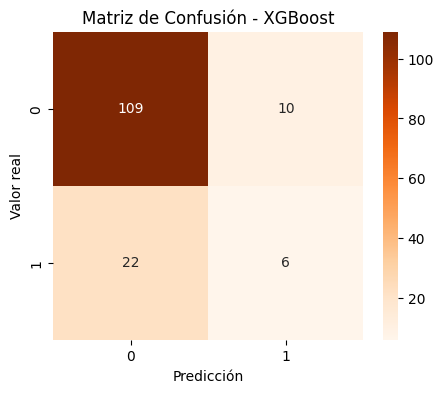

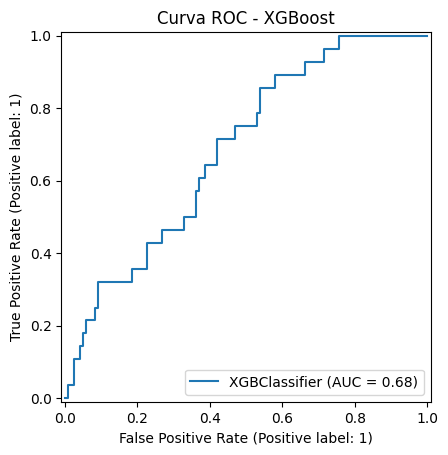

/tmp/ipython-input-3378236271.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Variable', data=importancias.head(10), palette='inferno')


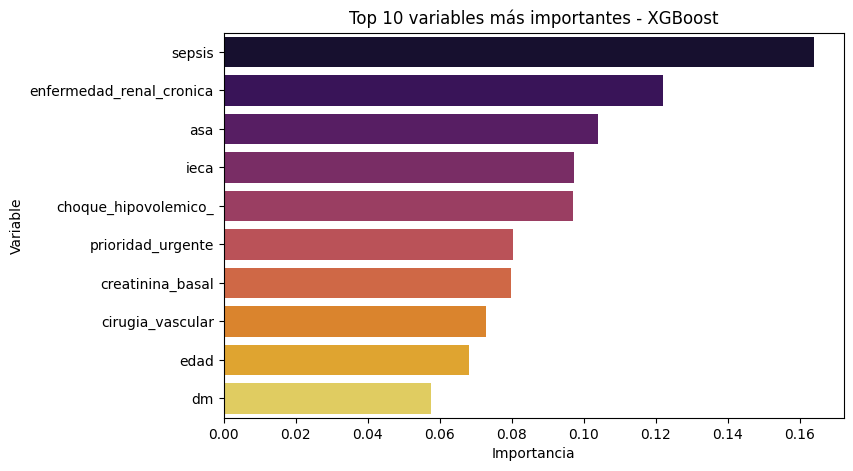

,Variable,Importancia
7,sepsis,0.163982
5,enfermedad_renal_cronica,0.121975
4,asa,0.104017
3,ieca,0.097416
8,choque_hipovolemico_,0.097052
10,prioridad_urgente,0.080257
6,creatinina_basal,0.079745
9,cirugia_vascular,0.072735
0,edad,0.068235
1,dm,0.057464


In [19]:
#Entrenamiento del modelo
xgb = XGBClassifier(
    n_estimators=300,        # número de árboles
    learning_rate=0.05,      # tasa de aprendizaje
    max_depth=3,             # profundidad de cada árbol
    subsample=0.8,           # fracción de datos por árbol
    colsample_bytree=0.8,    # fracción de variables por árbol
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb.fit(X_train_scaled_aki, y_train_aki)

#Predicciones
y_pred = xgb.predict(X_test_scaled_aki)
y_prob = xgb.predict_proba(X_test_scaled_aki)[:, 1]

#Métricas
print("===== MÉTRICAS XGBOOST =====")
print(f"Accuracy: {xgb.score(X_test_scaled_aki, y_test_aki):.3f}")
print(f"ROC-AUC:  {roc_auc_score(y_test_aki, y_prob):.3f}")
print("\nReporte de clasificación:")
print(classification_report(y_test_aki, y_pred))

#Matriz de confusión
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test_aki, y_pred), annot=True, fmt='d', cmap='Oranges')
plt.title('Matriz de Confusión - XGBoost')
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.show()

#Curva ROC
RocCurveDisplay.from_estimator(xgb, X_test_scaled_aki, y_test_aki)
plt.title('Curva ROC - XGBoost')
plt.show()

#Importancia de variables
importancias = pd.DataFrame({
    'Variable': X_train_aki.columns,
    'Importancia': xgb.feature_importances_
}).sort_values('Importancia', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x='Importancia', y='Variable', data=importancias.head(10), palette='inferno')
plt.title('Top 10 variables más importantes - XGBoost')
plt.show()

importancias.head(10)

####XG df_mimic

In [20]:
#Variables predictoras y objetivo
X_mimic = df_mimic.drop("lra", axis=1)
y_mimic = df_mimic["lra"]

#Dividir en entrenamiento y prueba
X_train_mimic, X_test_mimic, y_train_mimic, y_test_mimic = train_test_split(
    X_mimic, y_mimic, test_size=0.3, random_state=42, stratify=y_mimic
)


#Escalamiento (normalización)
scaler = StandardScaler()
X_train_scaled_mimic = scaler.fit_transform(X_train_mimic)
X_test_scaled_mimic = scaler.transform(X_test_mimic)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:43:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


===== MÉTRICAS XGBOOST =====
Accuracy: 0.632
ROC-AUC:  0.665

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.59      0.65      0.62       147
           1       0.68      0.62      0.65       174

    accuracy                           0.63       321
   macro avg       0.63      0.63      0.63       321
weighted avg       0.64      0.63      0.63       321



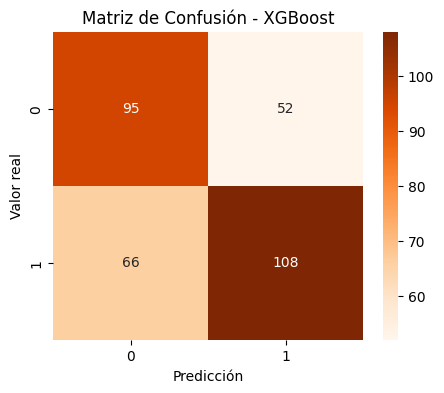

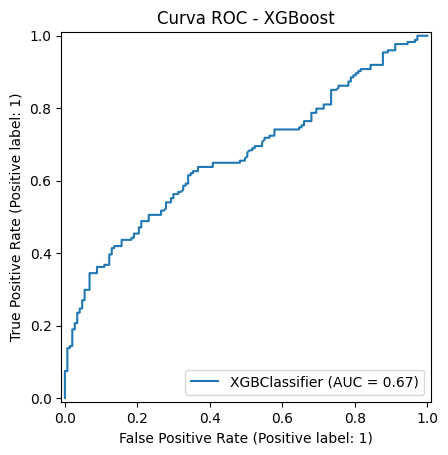

/tmp/ipython-input-3521076292.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Variable', data=importancias.head(10), palette='inferno')


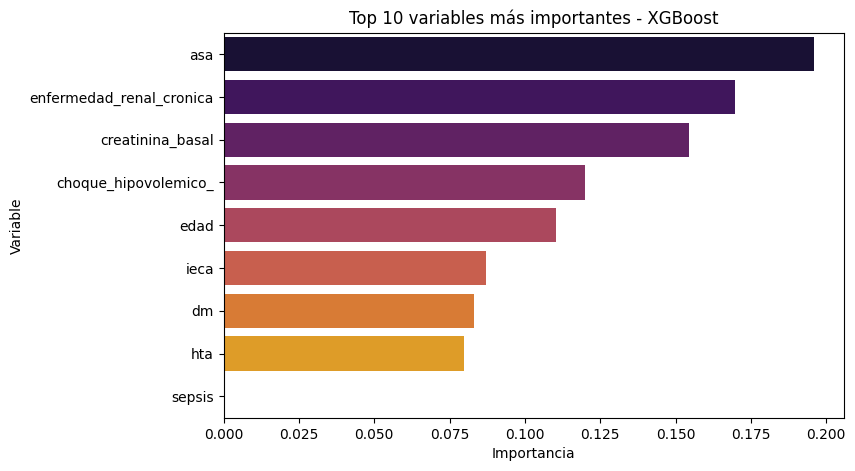

,Variable,Importancia
7,asa,0.195992
3,enfermedad_renal_cronica,0.169710
8,creatinina_basal,0.154316
5,choque_hipovolemico_,0.119957
0,edad,0.110263
6,ieca,0.087087
1,dm,0.083027
2,hta,0.079649
4,sepsis,0.000000


In [21]:
#Entrenamiento del modelo
xgb = XGBClassifier(
    n_estimators=300,        # número de árboles
    learning_rate=0.05,      # tasa de aprendizaje
    max_depth=3,             # profundidad de cada árbol
    subsample=0.8,           # fracción de datos por árbol
    colsample_bytree=0.8,    # fracción de variables por árbol
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb.fit(X_train_scaled_mimic, y_train_mimic)

#Predicciones
y_pred = xgb.predict(X_test_scaled_mimic)
y_prob = xgb.predict_proba(X_test_scaled_mimic)[:, 1]

#Métricas
print("===== MÉTRICAS XGBOOST =====")
print(f"Accuracy: {xgb.score(X_test_scaled_mimic, y_test_mimic):.3f}")
print(f"ROC-AUC:  {roc_auc_score(y_test_mimic, y_prob):.3f}")
print("\nReporte de clasificación:")
print(classification_report(y_test_mimic, y_pred))

#Matriz de confusión
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test_mimic, y_pred), annot=True, fmt='d', cmap='Oranges')
plt.title('Matriz de Confusión - XGBoost')
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.show()

#Curva ROC
RocCurveDisplay.from_estimator(xgb, X_test_scaled_mimic, y_test_mimic)
plt.title('Curva ROC - XGBoost')
plt.show()

#Importancia de variables
importancias = pd.DataFrame({
    'Variable': X_train_mimic.columns,
    'Importancia': xgb.feature_importances_
}).sort_values('Importancia', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x='Importancia', y='Variable', data=importancias.head(10), palette='inferno')
plt.title('Top 10 variables más importantes - XGBoost')
plt.show()

importancias.head(10)

####XG df_udaki

In [22]:
#Variables predictoras y objetivo
X_udaki = df_udaki.drop("lra", axis=1)
y_udaki= df_udaki["lra"]

#Dividir en entrenamiento y prueba
X_train_udaki, X_test_udaki, y_train_udaki, y_test_udaki = train_test_split(
    X_udaki, y_udaki, test_size=0.3, random_state=42, stratify=y_udaki
)


#Escalamiento (normalización)
scaler = StandardScaler()
X_train_scaled_udaki = scaler.fit_transform(X_train_udaki)
X_test_scaled_udaki = scaler.transform(X_test_udaki)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:45:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


===== MÉTRICAS XGBOOST =====
Accuracy: 0.654
ROC-AUC:  0.686

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.68      0.75      0.71       266
           1       0.62      0.52      0.57       202

    accuracy                           0.65       468
   macro avg       0.65      0.64      0.64       468
weighted avg       0.65      0.65      0.65       468



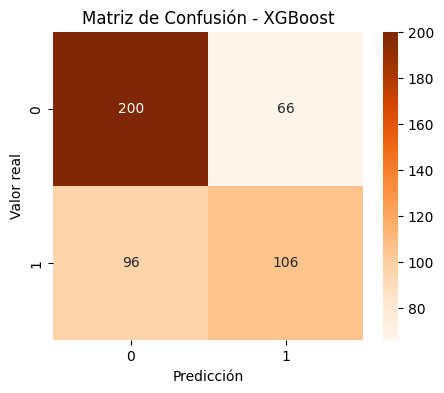

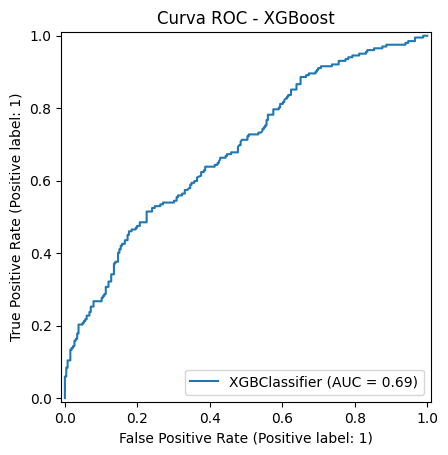

/tmp/ipython-input-1656711334.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Variable', data=importancias.head(10), palette='inferno')


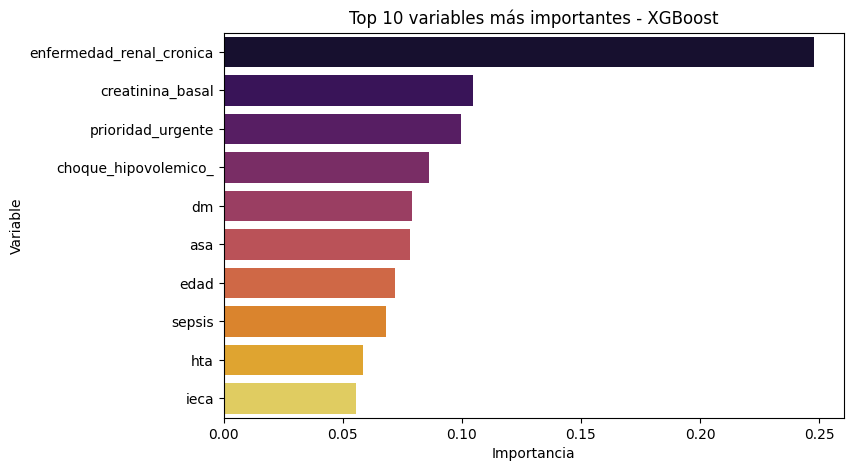

,Variable,Importancia
5,enfermedad_renal_cronica,0.247867
6,creatinina_basal,0.104591
10,prioridad_urgente,0.099423
8,choque_hipovolemico_,0.086385
1,dm,0.079085
4,asa,0.078156
0,edad,0.072050
7,sepsis,0.068340
2,hta,0.058446
3,ieca,0.055497


In [23]:
#Entrenamiento del modelo
xgb = XGBClassifier(
    n_estimators=300,        # número de árboles
    learning_rate=0.05,      # tasa de aprendizaje
    max_depth=3,             # profundidad de cada árbol
    subsample=0.8,           # fracción de datos por árbol
    colsample_bytree=0.8,    # fracción de variables por árbol
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb.fit(X_train_scaled_udaki, y_train_udaki)

#Predicciones
y_pred = xgb.predict(X_test_scaled_udaki)
y_prob = xgb.predict_proba(X_test_scaled_udaki)[:, 1]

#Métricas
print("===== MÉTRICAS XGBOOST =====")
print(f"Accuracy: {xgb.score(X_test_scaled_udaki, y_test_udaki):.3f}")
print(f"ROC-AUC:  {roc_auc_score(y_test_udaki, y_prob):.3f}")
print("\nReporte de clasificación:")
print(classification_report(y_test_udaki, y_pred))

#Matriz de confusión
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test_udaki, y_pred), annot=True, fmt='d', cmap='Oranges')
plt.title('Matriz de Confusión - XGBoost')
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.show()

#Curva ROC
RocCurveDisplay.from_estimator(xgb, X_test_scaled_udaki, y_test_udaki)
plt.title('Curva ROC - XGBoost')
plt.show()

#Importancia de variables
importancias = pd.DataFrame({
    'Variable': X_train_udaki.columns,
    'Importancia': xgb.feature_importances_
}).sort_values('Importancia', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x='Importancia', y='Variable', data=importancias.head(10), palette='inferno')
plt.title('Top 10 variables más importantes - XGBoost')
plt.show()

importancias.head(10)

In [24]:
model_metrics = {
    'Model': ['XGBoost (df_aki)', 'XGBoost (df_mimic)', 'XGBoost (df_udaki)'],
    'Accuracy': [0.782, 0.632, 0.654],
    'ROC-AUC': [0.685, 0.665, 0.686],
    'Precision (weighted avg)': [0.75, 0.64, 0.65],
    'Recall (weighted avg)': [0.78, 0.63, 0.65],
    'F1-Score (weighted avg)': [0.76, 0.63, 0.65]
}

df_metrics = pd.DataFrame(model_metrics)
print(df_metrics.to_markdown(index=False))

| Model              |   Accuracy |   ROC-AUC |   Precision (weighted avg) |   Recall (weighted avg) |   F1-Score (weighted avg) |
|:-------------------|-----------:|----------:|---------------------------:|------------------------:|--------------------------:|
| XGBoost (df_aki)   |      0.782 |     0.685 |                       0.75 |                    0.78 |                      0.76 |
| XGBoost (df_mimic) |      0.632 |     0.665 |                       0.64 |                    0.63 |                      0.63 |
| XGBoost (df_udaki) |      0.654 |     0.686 |                       0.65 |                    0.65 |                      0.65 |


In [25]:
df_metrics.head()

,Model,Accuracy,ROC-AUC,Precision (weighted avg),Recall (weighted avg),F1-Score (weighted avg)
0,XGBoost (df_aki),0.782,0.685,0.75,0.78,0.76
1,XGBoost (df_mimic),0.632,0.665,0.64,0.63,0.63
2,XGBoost (df_udaki),0.654,0.686,0.65,0.65,0.65
